# Example of p53 Quantification

Here we present the third of three examples that cover the main analyses performed in the paper. As illustrative cases of study, we use a representative gastruloid dataset to demonstrate the full analysis pipeline, from raw data processing to the extraction of quantitative readouts. The steps shown in this third example are the following: 

- Compute spillover coefficients and background.
- Segmetation and debris removal.
- Correction of cell misclassification.
- p53 quantification.

This third example focuses on the quantification of p53 and it's processing steps. Dendisy, neighborhood composition and radial distribution of cells are considered on `example1.ipynb` whereas YAP quantification is considered on `example2.ipynb`

### Spillover correction

To remove spectral spillover from the nuclear lineage markers (emiRFP or mCherry) into the p53 channel, we apply a global linear calibration model at the pixel level.

For each z-plane, we assume that the measured p53 signal is given by

$$
C \approx b_0(z) + s \cdot B
$$

where  
- $B$ is the fluorescence intensity of the lineage marker channel (emiRFP or mCherry),  
- $s$ is a global spillover coefficient shared across all z-planes, and  
- $b_0(z)$ is a z-dependent baseline offset accounting for background and plane-specific effects.

We do the analysis per z-plane because the intensity decays as we go deeper into the gastruloid.

#### Estimation of spillover parameters

The spillover slope $s$ is estimated globally by fitting a linear model between the p53 channel and the marker channel using all **in-cell pixels** across z-planes.

Once $s$ is known, the baseline for each z-plane is computed as

$$
b_0(z) = \mathrm{median}\!\left(C - s \cdot B\right)
$$

which provides a robust estimate of the background-corrected p53 offset in that plane.

The global spillover coefficient $s$ and the per-plane baselines $b_0(z)$ are saved for reuse in downstream analyses.


#### Spillover-corrected p53 signal

The corrected p53 intensity for each pixel is computed as

$$
C_{\mathrm{corr}} = C - b_0(z) - s \cdot B
$$

This removes both marker bleed-through and z-dependent background, yielding a p53 signal suitable for quantitative single-cell analysis. In what follows, we show an example of how these parameters can be computed, and later applied to an example gastruloid. The computation of these parameters in done in a gastruloid with secondary-only staining of p53. We start by segmenting the cells in that gastruloid and removing debris and finally using those masks to fit the global linear calibration model.

Before any of that, we define helper functions that we will use during this process. 

In [1]:

def build_union_masks(CT_list):
    """
    Build per-z 2D boolean masks marking in-cell pixels from the union of all cells
    across provided CT objects (e.g., CT_F3 and CT_A12).
    Returns: list of length Z with arrays (Y, X) dtype=bool.
    """
    CT0 = CT_list[0]
    Z = CT0.hyperstack.shape[1]
    Y = CT0.hyperstack.shape[-2]
    X = CT0.hyperstack.shape[-1]
    Mz_list = [np.zeros((Y, X), dtype=bool) for _ in range(Z)]
    for CT in CT_list:
        for cell in CT.jitcells:
            z = int(cell.centers[0][0])
            if z < 0 or z >= Z:
                continue
            # find mask for this z
            try:
                zid = cell.zs[0].index(z)
            except ValueError:
                continue
            mask = cell.masks[0][zid]
            yy = mask[:, 1].astype(np.intp)
            xx = mask[:, 0].astype(np.intp)
            Mz_list[z][yy, xx] = True
    return Mz_list

def sample_indices(n, k):
    if (k is None) or (n <= k):
        return slice(None)
    return np.random.choice(n, size=k, replace=False)

def update_normal_eq_sums(x, y, sums):
    """
    Update sufficient statistics for OLS fit y = b0 + s*x
    sums is a dict with keys: N, sumx, sumy, sumxx, sumxy
    """
    if x.size == 0:
        return
    sums["N"]     += x.size
    sums["sumx"]  += float(np.sum(x))
    sums["sumy"]  += float(np.sum(y))
    sums["sumxx"] += float(np.sum(x * x))
    sums["sumxy"] += float(np.sum(x * y))

def solve_b0_s_from_sums(sums):
    N, sumx, sumy, sumxx, sumxy = sums["N"], sums["sumx"], sums["sumy"], sums["sumxx"], sums["sumxy"]
    denom = (N * sumxx - sumx**2)
    if denom == 0 or N == 0:
        return 0.0, 0.0
    s  = (N * sumxy - sumx * sumy) / denom
    b0 = (sumy - s * sumx) / N
    return float(b0), float(s)

def estimate_b0z_for_file(CT_ref, Mz_list, ch_B, ch_C, s_global):
    """Compute per-z baseline b0(z) = median( C - s_global * B ) over in-cell pixels."""
    Z = CT_ref.hyperstack.shape[1]
    b0z = np.full(Z, np.nan, dtype=np.float64)
    for z in range(Z):
        Mz = Mz_list[z]
        if not np.any(Mz):
            continue
        Bz = CT_ref.hyperstack[0, z, ch_B, :, :].astype(np.float64)
        Cz = CT_ref.hyperstack[0, z, ch_C, :, :].astype(np.float64)
        x  = Bz[Mz].ravel()
        y  = Cz[Mz].ravel()
        resid = y - s_global * x
        b0z[z] = np.median(resid)
    # Fill any empty planes with the median of available planes (fallback to 0)
    if np.any(np.isnan(b0z)):
        if np.any(~np.isnan(b0z)):
            fill = np.nanmedian(b0z)
        else:
            fill = 0.0
        b0z[np.isnan(b0z)] = fill
    return b0z

def correct_cell_pixels(CT_ref, mask, z, ch_B, ch_C, s, b0z):
    """Return per-pixel corrected C for one cell at plane z."""
    yy = mask[:, 1].astype(np.intp)
    xx = mask[:, 0].astype(np.intp)
    C_vals = CT_ref.hyperstack[0, z, ch_C, :, :][yy, xx].astype(np.float32)
    B_vals = CT_ref.hyperstack[0, z, ch_B, :, :][yy, xx].astype(np.float32)
    return C_vals - float(b0z[z]) - float(s) * B_vals


We then proceed to import the necessary packages.

In [2]:
from qlivecell import get_file_name, cellSegTrack, check_or_create_dir, get_file_names, fill_channels
import os
import numpy as np
import matplotlib.pyplot as plt

Next, the user must define the direct path to this example folder:

In [ ]:
### PATH TO THE EXAMPLES FOLDER ###
PATH = "path/to/examples/"

With this, we can define the file to which we want to segment and create a folder to store the segmentation results of the background computation gastruloid.

In [4]:
path_to_data_background = PATH+"gastruloid3_background.tif"
path_to_results_background = PATH+"results_example3_background/"
check_or_create_dir(path_to_results_background)
path_to_save_background = path_to_results_background+"segmentation"
check_or_create_dir(path_to_save_background)

#### Segmentation and debris removal

Similarly as we did on example1, first step of the analysis is to perform the segmentation using the `qlivecell`. For this particular example we will not use 3D concatenation as we did in `example2.ipynb`. The reason for this is that consecutive z planes where imaged 15µm apart, which makes it rare to have the cytoplasm and nucleus of a cell represented on two consecutive planes.Batch settings mainly define the format of the file (.tif in this case) and the main channel of the dataset, which in the case of StarDist segmentation, is going to be the segmented channel. This channels is also used to compute cell centroid.

In [5]:
# Set progress to false to not overflow with text the notebook.
import qlivecell.config as cfg
cfg.PROGRESS = False

### LOAD STARDIST MODEL ###
from stardist.models import StarDist2D
model = StarDist2D.from_pretrained('2D_versatile_fluo')

### DEFINE ARGUMENTS ###
segmentation_args={
    'method': 'stardist2D', 
    'model': model, 
    'blur': [2,1], 
    'min_outline_length':100,
}

concatenation3D_args = {
    'do_3Dconcatenation': False
}

batch_args = {
    'name_format':"ch"+str(0)+"_{}",
    'extension':".tif",
} 

2026-01-12 23:20:32.698628: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-12 23:20:32.699835: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-12 23:20:32.719067: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-12 23:20:32.719815: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-12 23:20:33.223064: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


2026-01-12 23:20:33.960670: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-01-12 23:20:33.967765: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Now we can initialize the `cellSegTrack` objects which handle the segmentation. In this case, we will initialize two clases, one for the mCherry channel (F3) and one for the emiRFP channel (A12), run both segmentations and remove debris using the nuclear threshold computed on `example1.ipynb`. 

In [6]:
size_th_nucleus = 36.0 #µm

channel_names = ["A12", "p53", "F3", "DAPI"]

ch = channel_names.index("F3")
batch_args['name_format'] = "ch"+str(ch)+"_{}"
chans = fill_channels(channel=ch, channel_names=channel_names)
        
CT_F3 = cellSegTrack(
    path_to_data_background,
    path_to_save_background,
    segmentation_args=segmentation_args,
    concatenation3D_args=concatenation3D_args,
    batch_args=batch_args,
    channels=chans
)

ch = channel_names.index("A12")
batch_args['name_format'] = "ch"+str(ch)+"_{}"                
chans = fill_channels(channel=ch, channel_names=channel_names)

CT_A12 = cellSegTrack(
    path_to_data_background,
    path_to_save_background,
    segmentation_args=segmentation_args,
    concatenation3D_args=concatenation3D_args,
    batch_args=batch_args,
    channels=chans
)

CT_F3.run()
CT_A12.run()

labs_to_rem = []
for cell in CT_F3.jitcells:
    zc = int(cell.centers[0][0])
    zcid = cell.zs[0].index(zc)
    mask = cell.masks[0][zcid]
    area = len(mask) * CT_F3.metadata["XYresolution"]**2
    if area < size_th_nucleus:
        labs_to_rem.append(cell.label)

debris_F3 = len(labs_to_rem)
for lab in labs_to_rem:
    CT_F3._del_cell(lab)   
    
CT_F3.update_labels()

labs_to_rem = []
for cell in CT_A12.jitcells:
    zc = int(cell.centers[0][0])
    zcid = cell.zs[0].index(zc)
    mask = cell.masks[0][zcid]
    area = len(mask)* CT_A12.metadata["XYresolution"]**2
    if area < size_th_nucleus:
        labs_to_rem.append(cell.label)
    
debris_A12 = len(labs_to_rem)
for lab in labs_to_rem:
    CT_A12._del_cell(lab)  
    
CT_A12.update_labels()


###############           INIT ON BATCH MODE          ################
#                                                                    #
#   path to data = /home/pablo/Desktop/papers/GastruloidCompetition_paper/cell_competition_gastruloids/image-analysis/examples/gastruloid3_background.tif
#   path to save = /home/pablo/Desktop/papers/GastruloidCompetition_paper/cell_competition_gastruloids/image-analysis/examples/results_example3_background/segmentation/
#                                                                    #
#   No tracking method provided. Using greedy algorithm (if needed)  #
#                                                                    #
#   No time step provided, using 1 minute.                           #
#                                                                    #

###############           INIT ON BATCH MODE          ################
#                                                                    #
#   path to data = /home/pablo/Deskt

Now, with the segmentation done, we can fit the spillover model and save the results for later use. We will do this for both channels, emiRFP and mCherry. Let's start with the emiRFP channel.


###############           INIT ON BATCH MODE          ################
#                                                                    #
#   path to data = /home/pablo/Desktop/papers/GastruloidCompetition_paper/cell_competition_gastruloids/image-analysis/examples/gastruloid3_background.tif
#   path to save = /home/pablo/Desktop/papers/GastruloidCompetition_paper/cell_competition_gastruloids/image-analysis/examples/results_example3_background/segmentation/
#                                                                    #
#   No tracking method provided. Using greedy algorithm (if needed)  #
#                                                                    #
#   No time step provided, using 1 minute.                           #
#                                                                    #
###############        LOADING AND INITIALIZING       ################
#                                                                    #
#                                    

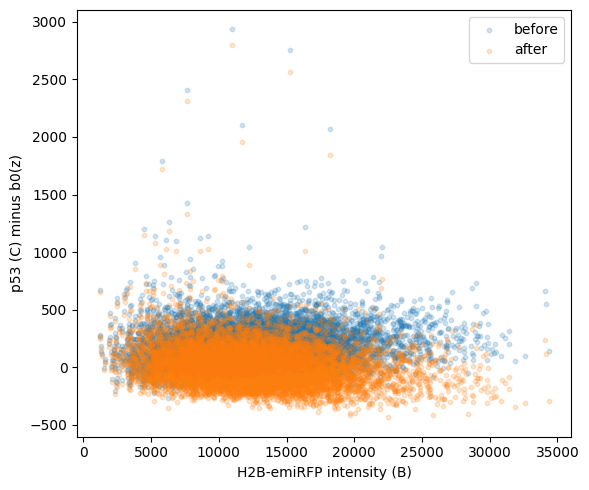

In [7]:

BLEED_FROM = "A12"   
C_CHANNEL  = "p53"

# We set a limit pixels per z-plane when fitting (to keep memory/time bounded).
# Set to None to use ALL in-cell pixels.
SAMPLE_PER_Z = 200_000


ch_B = channel_names.index(BLEED_FROM)
ch_C = channel_names.index(C_CHANNEL)

ch = channel_names.index(BLEED_FROM)
batch_args = {
    'name_format':"ch"+str(ch)+"_{}",
    'extension':".tif",
} 
chans = fill_channels(channel=ch, channel_names=channel_names)

CT = cellSegTrack(
    path_to_data_background,
    path_to_save_background,
    batch_args=batch_args,
    channels=chans
)
CT.load()

# Accumulate OLS sums across all files/z-planes
sums = {"N": 0, 
        "sumx": 0.0, 
        "sumy": 0.0, 
        "sumxx": 0.0, 
        "sumxy": 0.0
        }

# --- Union mask across both populations, per z ---
Mz_list = build_union_masks([CT])

Z = CT.hyperstack.shape[1]
for z in range(Z):
    Mz = Mz_list[z]
    if not np.any(Mz):
        continue
    Bz = CT.hyperstack[0, z, ch_B, :, :].astype(np.float64)
    Cz = CT.hyperstack[0, z, ch_C, :, :].astype(np.float64)

    x = Bz[Mz].ravel()
    y = Cz[Mz].ravel()

    # Optional subsample for speed
    sel = sample_indices(x.size, SAMPLE_PER_Z)
    x = x[sel]; y = y[sel]

    update_normal_eq_sums(x, y, sums)

# Solve for global (session) s and an overall b0 (we'll replace b0 by per-z b0z later)
b0_global, s_global = solve_b0_s_from_sums(sums)
print(f"[Calibration] Estimated global spillover s ({BLEED_FROM} → {C_CHANNEL}): {s_global:.6g}")
print(f"[Calibration] Global intercept b0 (unused; we’ll use per-z): {b0_global:.6g}")

b0z = estimate_b0z_for_file(CT, Mz_list, ch_B, ch_C, s_global)

# Save calibration alongside the file’s outputs (so you can reuse later)
calib_path = os.path.join(path_to_results_background, f"calibration_{BLEED_FROM}_to_{C_CHANNEL}.npz")
np.savez(calib_path, s=s_global, b0z=b0z, bleed_from=BLEED_FROM, c_channel=C_CHANNEL)
print(f"[Saved] {calib_path}  |  s={s_global:.6g}  median(b0z)={np.median(b0z):.6g}")

# Make a small scatter of (C - b0z[z]) vs B for a few planes, before vs after correction
fig, ax = plt.subplots(figsize=(6, 5))
z = 2
Mz = Mz_list[z]
Bz = CT.hyperstack[0, z, ch_B, :, :].astype(np.float64)
Cz = CT.hyperstack[0, z, ch_C, :, :].astype(np.float64)
x = Bz[Mz].ravel()
y = Cz[Mz].ravel()
sel = sample_indices(x.size, 10_000)
x = x[sel]; y = y[sel]
y0 = y - b0z[z]
ycorr = y - b0z[z] - s_global * x
ax.scatter(x, y0, s=10, alpha=0.2, label="before")
ax.scatter(x, ycorr, s=10, alpha=0.2, label="after")
ax.set_xlabel("H2B-emiRFP intensity (B)")
ax.set_ylabel(f"{C_CHANNEL} (C) minus b0(z)")
ax.legend()
plt.tight_layout()
plt.show()


Let's now compute it for the mCherry channel


###############           INIT ON BATCH MODE          ################
#                                                                    #
#   path to data = /home/pablo/Desktop/papers/GastruloidCompetition_paper/cell_competition_gastruloids/image-analysis/examples/gastruloid3_background.tif
#   path to save = /home/pablo/Desktop/papers/GastruloidCompetition_paper/cell_competition_gastruloids/image-analysis/examples/results_example3_background/segmentation/
#                                                                    #
#   No tracking method provided. Using greedy algorithm (if needed)  #
#                                                                    #
#   No time step provided, using 1 minute.                           #
#                                                                    #
###############        LOADING AND INITIALIZING       ################
#                                                                    #
#                                    

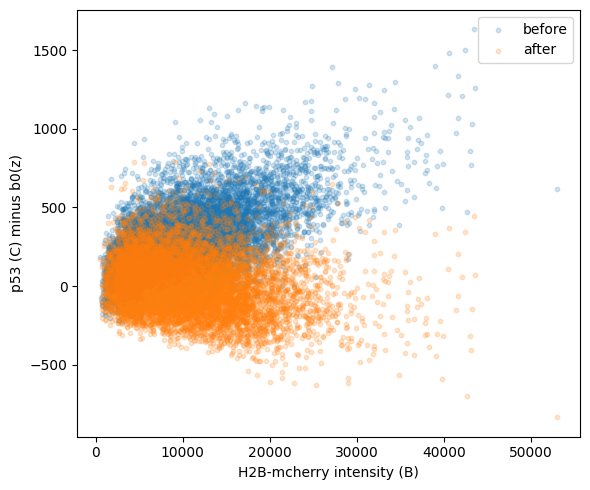

In [8]:

BLEED_FROM = "F3"   
C_CHANNEL  = "p53"

# We set a limit pixels per z-plane when fitting (to keep memory/time bounded).
# Set to None to use ALL in-cell pixels.
SAMPLE_PER_Z = 200_000


ch_B = channel_names.index(BLEED_FROM)
ch_C = channel_names.index(C_CHANNEL)

ch = channel_names.index(BLEED_FROM)
batch_args = {
    'name_format':"ch"+str(ch)+"_{}",
    'extension':".tif",
} 
chans = fill_channels(channel=ch, channel_names=channel_names)

CT = cellSegTrack(
    path_to_data_background,
    path_to_save_background,
    batch_args=batch_args,
    channels=chans
)
CT.load()

# Accumulate OLS sums across all files/z-planes
sums = {"N": 0, 
        "sumx": 0.0, 
        "sumy": 0.0, 
        "sumxx": 0.0, 
        "sumxy": 0.0
        }

# --- Union mask across both populations, per z ---
Mz_list = build_union_masks([CT])

Z = CT.hyperstack.shape[1]
for z in range(Z):
    Mz = Mz_list[z]
    if not np.any(Mz):
        continue
    Bz = CT.hyperstack[0, z, ch_B, :, :].astype(np.float64)
    Cz = CT.hyperstack[0, z, ch_C, :, :].astype(np.float64)

    x = Bz[Mz].ravel()
    y = Cz[Mz].ravel()

    # Optional subsample for speed
    sel = sample_indices(x.size, SAMPLE_PER_Z)
    x = x[sel]; y = y[sel]

    update_normal_eq_sums(x, y, sums)

# Solve for global (session) s and an overall b0 (we'll replace b0 by per-z b0z later)
b0_global, s_global = solve_b0_s_from_sums(sums)
print(f"[Calibration] Estimated global spillover s ({BLEED_FROM} → {C_CHANNEL}): {s_global:.6g}")
print(f"[Calibration] Global intercept b0 (unused; we’ll use per-z): {b0_global:.6g}")

b0z = estimate_b0z_for_file(CT, Mz_list, ch_B, ch_C, s_global)

# Save calibration alongside the file’s outputs (so you can reuse later)
calib_path = os.path.join(path_to_results_background, f"calibration_{BLEED_FROM}_to_{C_CHANNEL}.npz")
np.savez(calib_path, s=s_global, b0z=b0z, bleed_from=BLEED_FROM, c_channel=C_CHANNEL)
print(f"[Saved] {calib_path}  |  s={s_global:.6g}  median(b0z)={np.median(b0z):.6g}")

# Make a small scatter of (C - b0z[z]) vs B for a few planes, before vs after correction
fig, ax = plt.subplots(figsize=(6, 5))
z = 2
Mz = Mz_list[z]
Bz = CT.hyperstack[0, z, ch_B, :, :].astype(np.float64)
Cz = CT.hyperstack[0, z, ch_C, :, :].astype(np.float64)
x = Bz[Mz].ravel()
y = Cz[Mz].ravel()
sel = sample_indices(x.size, 10_000)
x = x[sel]; y = y[sel]
y0 = y - b0z[z]
ycorr = y - b0z[z] - s_global * x
ax.scatter(x, y0, s=10, alpha=0.2, label="before")
ax.scatter(x, ycorr, s=10, alpha=0.2, label="after")
ax.set_xlabel("H2B-mcherry intensity (B)")
ax.set_ylabel(f"{C_CHANNEL} (C) minus b0(z)")
ax.legend()
plt.tight_layout()
plt.show()


In the scatter plots shown above, we can see there is a clear bleed through from the mCherry channel but not from the emiRFP into the p53 channel. With this, we can jump into the segmenting the main dataset used for quantification.

### Segmentation and debris removal

The settings used for this are the same as in the background gastruloid.

In [9]:
path_to_data = PATH+"gastruloid3.tif"
path_to_results = PATH+"results_example3/"
check_or_create_dir(path_to_results)
path_to_save = path_to_results+"segmentation"
check_or_create_dir(path_to_save)

ch = channel_names.index("F3")
batch_args['name_format'] = "ch"+str(ch)+"_{}"
chans = fill_channels(channel=ch, channel_names=channel_names)
        
CT_F3 = cellSegTrack(
    path_to_data,
    path_to_save,
    segmentation_args=segmentation_args,
    concatenation3D_args=concatenation3D_args,
    batch_args=batch_args,
    channels=chans
)

ch = channel_names.index("A12")
batch_args['name_format'] = "ch"+str(ch)+"_{}"                
chans = fill_channels(channel=ch, channel_names=channel_names)

CT_A12 = cellSegTrack(
    path_to_data,
    path_to_save,
    segmentation_args=segmentation_args,
    concatenation3D_args=concatenation3D_args,
    batch_args=batch_args,
    channels=chans
)

CT_F3.run()
CT_A12.run()

labs_to_rem = []
for cell in CT_F3.jitcells:
    zc = int(cell.centers[0][0])
    zcid = cell.zs[0].index(zc)
    mask = cell.masks[0][zcid]
    area = len(mask) * CT_F3.metadata["XYresolution"]**2
    if area < size_th_nucleus:
        labs_to_rem.append(cell.label)

debris_F3 = len(labs_to_rem)
for lab in labs_to_rem:
    CT_F3._del_cell(lab)   
    
CT_F3.update_labels()

labs_to_rem = []
for cell in CT_A12.jitcells:
    zc = int(cell.centers[0][0])
    zcid = cell.zs[0].index(zc)
    mask = cell.masks[0][zcid]
    area = len(mask)* CT_A12.metadata["XYresolution"]**2
    if area < size_th_nucleus:
        labs_to_rem.append(cell.label)
    
debris_A12 = len(labs_to_rem)
for lab in labs_to_rem:
    CT_A12._del_cell(lab)  
    
CT_A12.update_labels()


###############           INIT ON BATCH MODE          ################
#                                                                    #
#   path to data = /home/pablo/Desktop/papers/GastruloidCompetition_paper/cell_competition_gastruloids/image-analysis/examples/gastruloid3.tif
#   path to save = /home/pablo/Desktop/papers/GastruloidCompetition_paper/cell_competition_gastruloids/image-analysis/examples/results_example3/segmentation/
#                                                                    #
#   No tracking method provided. Using greedy algorithm (if needed)  #
#                                                                    #
#   No time step provided, using 1 minute.                           #
#                                                                    #

###############           INIT ON BATCH MODE          ################
#                                                                    #
#   path to data = /home/pablo/Desktop/papers/GastruloidCo

### Cell misclassification

In this dataset, we noticed some cells that were misclassified or present in both channels. To remove these, we did the following:
- Segmented cell in the mCherry and emiRFP channels (done above)
- Quantified mCherry and emiRFP signal in all segmented cells. 
- Fit a K-means cluster model with two clasters with the resulting quantification. 
- Remove cells outside their corresponding cluster based on the channel they were segmented.

Therefore, the next step is to quantify both channels and clusterize cells. This is done per z-plane to avoid problems derived from the decay of signal as we go deeper in the gastruloid.

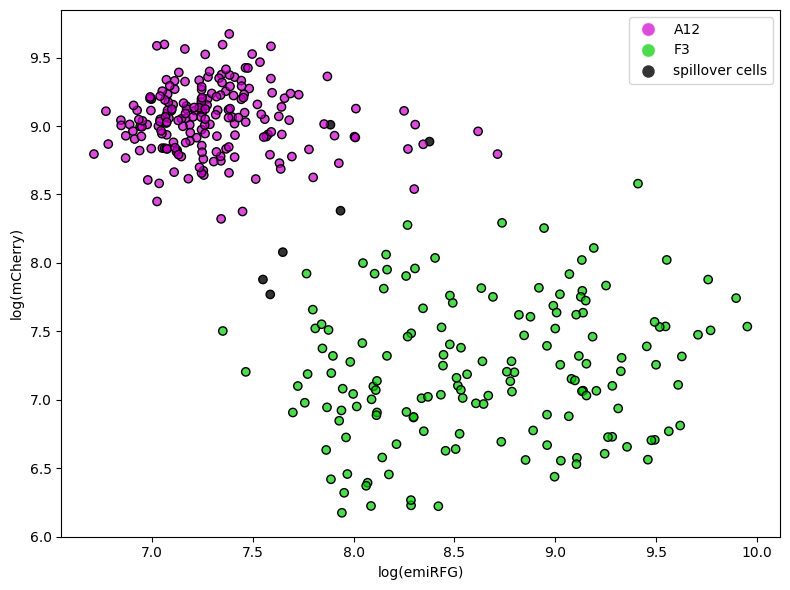

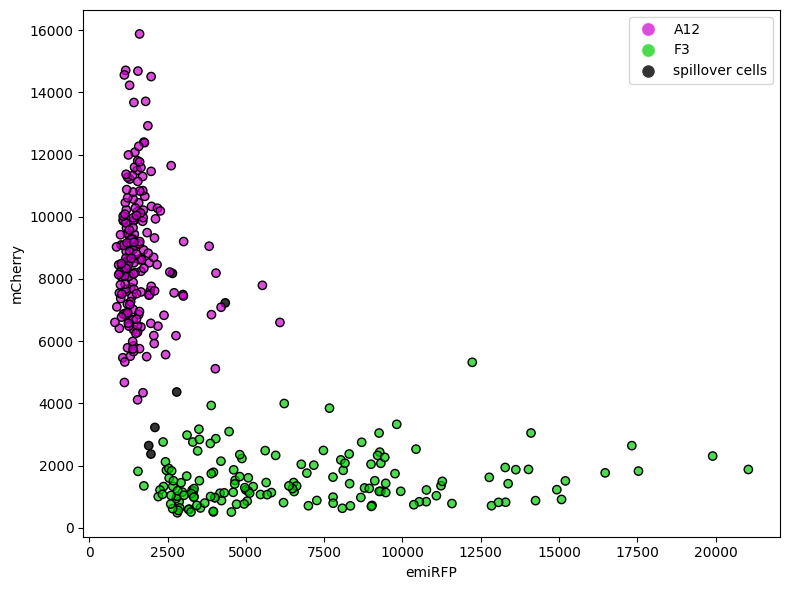

In [10]:

ch_F3 = channel_names.index("F3")
ch_A12 = channel_names.index("A12")

F3_all = [[] for z in range(10)]
A12_all = [[] for z in range(10)]

colors = [[] for z in range(10)]
fates = [[] for z in range(10)]

for cell in CT_F3.jitcells:
    center = cell.centers[0]
    z = int(center[0])

    zid = cell.zs[0].index(z)
    mask = cell.masks[0][zid]

    F3_all[z].append(np.mean(CT_A12.hyperstack[0,z,ch_F3,:,:][mask[:,1], mask[:,0]]))
    A12_all[z].append(np.mean(CT_A12.hyperstack[0,z,ch_A12,:,:][mask[:,1], mask[:,0]]))

    colors[z].append([0.0,0.8,0.0, 0.3])
    fates[z].append("F3")

for cell in CT_A12.jitcells:
    center = cell.centers[0]
    z = int(center[0])
    zid = cell.zs[0].index(z)
    mask = cell.masks[0][zid]

    F3_all[z].append(np.mean(CT_A12.hyperstack[0,z,ch_F3,:,:][mask[:,1], mask[:,0]]))
    A12_all[z].append(np.mean(CT_A12.hyperstack[0,z,ch_A12,:,:][mask[:,1], mask[:,0]]))    
          
    colors[z].append([0.8,0.0,0.8, 0.3])
    fates[z].append("A12")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


remove_cell = [[] for z in range(10)]

for z in range(10):
    data1 = F3_all[z]
    data2 = A12_all[z]
    checkvar = fates[z]
    X = np.transpose(np.asarray([np.log(data1), np.log(data2)]))

    kmeans = KMeans(n_clusters=2)
    kmeans.fit(X)
    cluster_centers = kmeans.cluster_centers_
    clustered_fates = np.argsort(cluster_centers[:,0])
    labels = kmeans.labels_

    colors_clustering = []

    A12th = np.percentile(data2,20)
    F3th = np.percentile(data1,20)

    for i, lab in enumerate(labels):
        if lab==clustered_fates[0]:
            if checkvar[i]!="A12":
                colors_clustering.append([0.2, 0.2, 0.2, 1.0])
                remove_cell[z].append(True)
            else:
                colors_clustering.append([0.8, 0.0, 0.8, 0.7])
                remove_cell[z].append(False)
        elif lab==clustered_fates[-1]:
            if checkvar[i]!="F3":
                colors_clustering.append([0.2, 0.2, 0.2, 1.0])
                remove_cell[z].append(True)
            else:
                remove_cell[z].append(False)
                colors_clustering.append([0.0, 0.8, 0.0, 0.7])
        else:
            remove_cell[z].append(False)
            colors_clustering.append([0.0, 0.0, 0.0, 0.7])

        if checkvar[i]=="A12":
            if data2[i] < A12th:
                remove_cell[z][-1]=True
                colors_clustering[-1] = [0.2, 0.2, 0.2, 1.0]
        else:
            if data1[i] < F3th:
                remove_cell[z][-1]=True
                colors_clustering[-1] = [0.2, 0.2, 0.2, 1.0]
            
    if z ==5:
        # Plot the original data points and cluster centers
        from matplotlib.lines import Line2D
        plt.figure(figsize=(8, 6))
        plt.scatter(X[:, 0], X[:, 1], c=colors_clustering, edgecolors='k')
        plt.xlabel('log(emiRFG)')
        plt.ylabel('log(mCherry)')
        plt.tight_layout()

        # Custom legend handles
        legend_elements = [
            Line2D([0], [0], marker="o", color="w", label="A12",
                markerfacecolor=(0.8, 0.0, 0.8, 0.7), markersize=10),
            Line2D([0], [0], marker="o", color="w", label="F3",
                markerfacecolor=(0.0, 0.8, 0.0, 0.7), markersize=10),
            Line2D([0], [0], marker="o", color="w", label="spillover cells",
                markerfacecolor=(0.2, 0.2, 0.2, 1.0), markersize=10),
        ]
        plt.legend(handles=legend_elements, loc="best", frameon=True)
        plt.show()

        plt.figure(figsize=(8, 6))
        plt.scatter(data1, data2, c=colors_clustering, edgecolors='k')
        plt.xlabel('emiRFP')
        plt.ylabel('mCherry')
        plt.tight_layout()

        # Custom legend handles
        legend_elements = [
            Line2D([0], [0], marker="o", color="w", label="A12",
                markerfacecolor=(0.8, 0.0, 0.8, 0.7), markersize=10),
            Line2D([0], [0], marker="o", color="w", label="F3",
                markerfacecolor=(0.0, 0.8, 0.0, 0.7), markersize=10),
            Line2D([0], [0], marker="o", color="w", label="spillover cells",
                markerfacecolor=(0.2, 0.2, 0.2, 1.0), markersize=10),
        ]
        plt.legend(handles=legend_elements, loc="best", frameon=True)
        plt.show()



Onces the misclassified cells are detected we can remove them and progress with the analysis.

In [11]:
current_zid = [0 for z in range(10)]

labs_to_rem = []
for cell in CT_F3.jitcells:
    center = cell.centers[0]
    z = int(center[0])
    if remove_cell[z][current_zid[z]]:
        labs_to_rem.append(cell.label)
    current_zid[z]+=1

for lab in labs_to_rem:
    CT_F3._del_cell(lab)  
    
CT_F3.update_labels() 

labs_to_rem = []
for cell in CT_A12.jitcells:
    center = cell.centers[0]
    z = int(center[0])
    if remove_cell[z][current_zid[z]]:
        labs_to_rem.append(cell.label)
    current_zid[z]+=1

for lab in labs_to_rem:
    CT_A12._del_cell(lab)  
    
CT_A12.update_labels() 


We can now check that the removal worked as expected

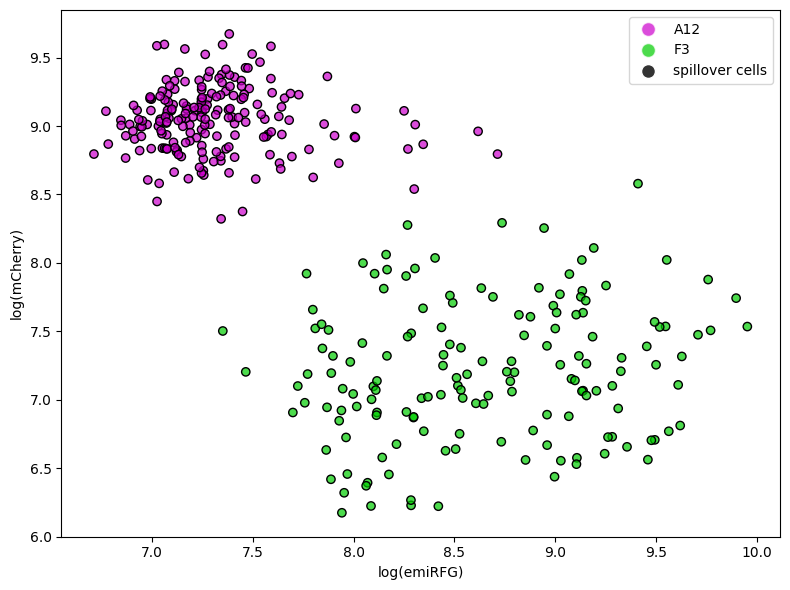

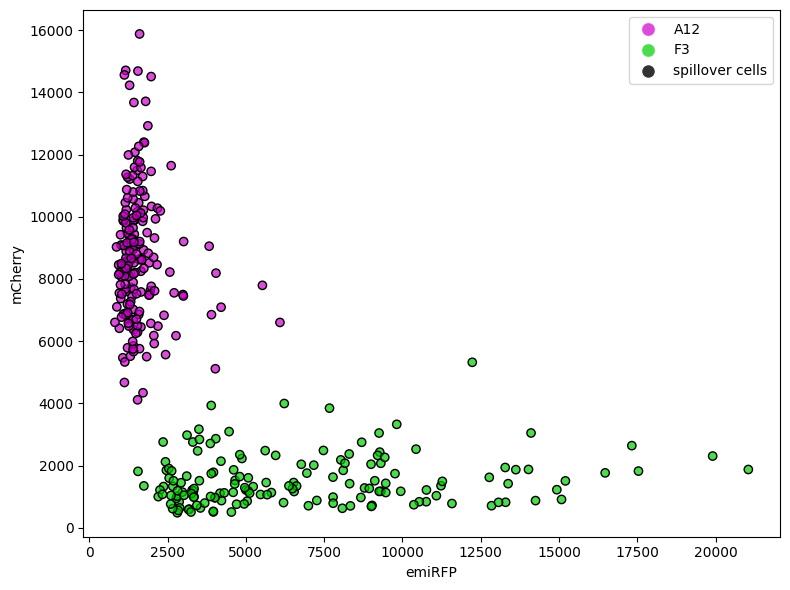

In [12]:
F3_all = [[] for z in range(10)]
A12_all = [[] for z in range(10)]

colors = [[] for z in range(10)]
fates = [[] for z in range(10)]

for cell in CT_F3.jitcells:
    center = cell.centers[0]
    z = int(center[0])

    zid = cell.zs[0].index(z)
    mask = cell.masks[0][zid]

    F3_all[z].append(np.mean(CT_A12.hyperstack[0,z,ch_F3,:,:][mask[:,1], mask[:,0]]))
    A12_all[z].append(np.mean(CT_A12.hyperstack[0,z,ch_A12,:,:][mask[:,1], mask[:,0]]))

    colors[z].append([0.0,0.8,0.0, 0.3])
    fates[z].append("F3")

for cell in CT_A12.jitcells:
    center = cell.centers[0]
    z = int(center[0])
    zid = cell.zs[0].index(z)
    mask = cell.masks[0][zid]

    F3_all[z].append(np.mean(CT_A12.hyperstack[0,z,ch_F3,:,:][mask[:,1], mask[:,0]]))
    A12_all[z].append(np.mean(CT_A12.hyperstack[0,z,ch_A12,:,:][mask[:,1], mask[:,0]]))    
          
    colors[z].append([0.8,0.0,0.8, 0.3])
    fates[z].append("A12")

remove_cell = [[] for z in range(10)]

for z in range(10):
    data1 = F3_all[z]
    data2 = A12_all[z]
    checkvar = fates[z]
    X = np.transpose(np.asarray([np.log(data1), np.log(data2)]))

    kmeans = KMeans(n_clusters=2)
    kmeans.fit(X)
    cluster_centers = kmeans.cluster_centers_
    clustered_fates = np.argsort(cluster_centers[:,0])
    labels = kmeans.labels_

    colors_clustering = []

    A12th = np.percentile(data2,20)
    F3th = np.percentile(data1,20)

    for i, lab in enumerate(labels):
        if lab==clustered_fates[0]:
            if checkvar[i]!="A12":
                colors_clustering.append([0.2, 0.2, 0.2, 1.0])
                remove_cell[z].append(True)
            else:
                colors_clustering.append([0.8, 0.0, 0.8, 0.7])
                remove_cell[z].append(False)
        elif lab==clustered_fates[-1]:
            if checkvar[i]!="F3":
                colors_clustering.append([0.2, 0.2, 0.2, 1.0])
                remove_cell[z].append(True)
            else:
                remove_cell[z].append(False)
                colors_clustering.append([0.0, 0.8, 0.0, 0.7])
        else:
            remove_cell[z].append(False)
            colors_clustering.append([0.0, 0.0, 0.0, 0.7])

        if checkvar[i]=="A12":
            if data2[i] < A12th:
                remove_cell[z][-1]=True
                colors_clustering[-1] = [0.2, 0.2, 0.2, 1.0]
        else:
            if data1[i] < F3th:
                remove_cell[z][-1]=True
                colors_clustering[-1] = [0.2, 0.2, 0.2, 1.0]
            
    if z ==5:
        # Plot the original data points and cluster centers
        from matplotlib.lines import Line2D
        plt.figure(figsize=(8, 6))
        plt.scatter(X[:, 0], X[:, 1], c=colors_clustering, edgecolors='k')
        plt.xlabel('log(emiRFG)')
        plt.ylabel('log(mCherry)')
        plt.tight_layout()

        # Custom legend handles
        legend_elements = [
            Line2D([0], [0], marker="o", color="w", label="A12",
                markerfacecolor=(0.8, 0.0, 0.8, 0.7), markersize=10),
            Line2D([0], [0], marker="o", color="w", label="F3",
                markerfacecolor=(0.0, 0.8, 0.0, 0.7), markersize=10),
            Line2D([0], [0], marker="o", color="w", label="spillover cells",
                markerfacecolor=(0.2, 0.2, 0.2, 1.0), markersize=10),
        ]
        plt.legend(handles=legend_elements, loc="best", frameon=True)
        plt.show()

        plt.figure(figsize=(8, 6))
        plt.scatter(data1, data2, c=colors_clustering, edgecolors='k')
        plt.xlabel('emiRFP')
        plt.ylabel('mCherry')
        plt.tight_layout()

        # Custom legend handles
        legend_elements = [
            Line2D([0], [0], marker="o", color="w", label="A12",
                markerfacecolor=(0.8, 0.0, 0.8, 0.7), markersize=10),
            Line2D([0], [0], marker="o", color="w", label="F3",
                markerfacecolor=(0.0, 0.8, 0.0, 0.7), markersize=10),
            Line2D([0], [0], marker="o", color="w", label="spillover cells",
                markerfacecolor=(0.2, 0.2, 0.2, 1.0), markersize=10),
        ]
        plt.legend(handles=legend_elements, loc="best", frameon=True)
        plt.show()

### p53 quantification

Finally, we can quantify nuclear p53 as we have done with other markers on examples 1 and 2. In this case, due to the nature of the p53 distributions, we show the results using violin plot.

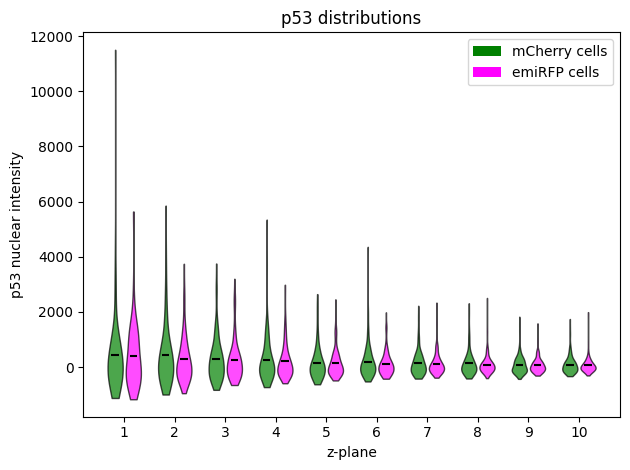

In [13]:
ch_p53 = channel_names.index("p53")

calibF3 = np.load("{}calibration_F3_to_p53.npz".format(path_to_results_background))
p53_F3_s_global = float(calibF3["s"])
p53_F3_0z = calibF3["b0z"]

calibA12 = np.load("{}calibration_A12_to_p53.npz".format(path_to_results_background))
p53_A12_s_global = float(calibA12["s"])
p53_A12_0z = calibA12["b0z"]


Mz_list = build_union_masks([CT_F3])
p53_F3_0z = estimate_b0z_for_file(CT_F3, Mz_list, ch_F3, ch_p53, p53_F3_s_global)

stack_p53 = CT_A12.hyperstack[0,:,ch_p53].astype("float64")

F3_p53 = [[] for z in range(10)]
A12_p53 = [[] for z in range(10)]
        
for cell in CT_F3.jitcells:
    center = cell.centers[0]
    z = int(center[0])
    zid = cell.zs[0].index(z)
    mask = cell.masks[0][zid]

    Ccorr_vals = correct_cell_pixels(CT_F3, mask, z, ch_F3, ch_p53, p53_F3_s_global, p53_F3_0z)
    p53_val = float(np.mean(Ccorr_vals))
    F3_p53[z].append(p53_val)
        

Mz_list = build_union_masks([CT_A12])
p53_A12_0z = estimate_b0z_for_file(CT_A12, Mz_list, ch_A12, ch_p53, p53_A12_s_global)

for cell in CT_A12.jitcells:
    center = cell.centers[0]
    z = int(center[0])
    zid = cell.zs[0].index(z)
    mask = cell.masks[0][zid]

    Ccorr_vals = correct_cell_pixels(CT_A12, mask, z, ch_A12, ch_p53, p53_A12_s_global, p53_A12_0z)
    p53_val = float(np.mean(Ccorr_vals))
    A12_p53[z].append(p53_val)


F3_means = np.array([np.mean(x) for x in F3_p53])
F3_stds  = np.array([np.std(x)  for x in F3_p53])

A12_means = np.array([np.mean(x) for x in A12_p53])
A12_stds  = np.array([np.std(x)  for x in A12_p53])


n = 10
x = np.arange(n)
offset = 0.18

v1 = plt.violinplot(
    F3_p53,
    positions=x - offset,
    widths=0.3,
    showmeans=True,
    showextrema=False
)

for body in v1['bodies']:
    body.set_facecolor("green")
    body.set_edgecolor("black")
    body.set_alpha(0.7)

v1['cmeans'].set_color("black")

v2 = plt.violinplot(
    A12_p53,
    positions=x + offset,
    widths=0.3,
    showmeans=True,
    showextrema=False
)

for body in v2['bodies']:
    body.set_facecolor("magenta")
    body.set_edgecolor("black")
    body.set_alpha(0.7)

v2['cmeans'].set_color("black")

plt.xticks(x, [f"{i+1}" for i in range(10)])
plt.xlabel("z-plane")
plt.ylabel("p53 nuclear intensity")
plt.title("p53 distributions")

# Legend (manual)
from matplotlib.patches import Patch
plt.legend(handles=[
    Patch(facecolor="green", label="mCherry cells"),
    Patch(facecolor="magenta", label="emiRFP cells")
])

plt.tight_layout()
plt.show()


End of the Notebook